<a href="https://www.kaggle.com/code/dewizzz/lalalayeyeyelulusfixed?scriptVersionId=142662239" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/dewizzz/lalalayeyeyelulusfixed?scriptVersionId=138655296" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="background-color:#F0E68C;font-family:Halvetica;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Deteksi Autisme</b></h1>

In [1]:
import os
import time
import torch
import seaborn as sn
import pandas as pd
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm
import torch.nn.functional as F

# **Load Data**

In [2]:
# Path ke folder kelas 1
folder_kelas_1 = '/kaggle/input/data-skripsi/Data Skripsi/Kelas Autisme'

# Path ke folder kelas 0
folder_kelas_0 = '/kaggle/input/data-skripsi/Data Skripsi/Kelas TC'

# Inisialisasi dictionary untuk menyimpan label
label_gambar = {}

# Melabeli gambar-gambar dalam folder kelas 1
for file in os.listdir(folder_kelas_1):
    if file.endswith('.gif'):
        label_gambar[file] = 1  # Label kelas 1

# Melabeli gambar-gambar dalam folder kelas 0
for file in os.listdir(folder_kelas_0):
    if file.endswith('.gif'):
        label_gambar[file] = 0  # Label kelas 0

In [3]:
# Mencetak hasil labeling untuk 5 gambar dari setiap kelas
count_kelas_0 = 0
count_kelas_1 = 0

for file, label in label_gambar.items():
    if label == 0 and count_kelas_0 < 5:
        print(f"File: {file}, Label: {label}")
        count_kelas_0 += 1
    elif label == 1 and count_kelas_1 < 5:
        print(f"File: {file}, Label: {label}")
        count_kelas_1 += 1
    
    if count_kelas_0 == 5 and count_kelas_1 == 5:
        break

File: GU_28824_1.gif, Label: 1
File: UCD_30014_1.gif, Label: 1
File: GU_28818_1.gif, Label: 1
File: SDSU_28873_1.gif, Label: 1
File: KUL_29800_1.gif, Label: 1
File: GU_28757_1.gif, Label: 0
File: KKI_29470_1.gif, Label: 0
File: KKI_29295_1.gif, Label: 0
File: KKI_29329_1.gif, Label: 0
File: OHSU_28950_1.gif, Label: 0


In [4]:
# Transformasi untuk data gambar GIF
class GIFToTensor(object):
    def __call__(self, pic):
        if pic.mode != 'RGB':
            pic = pic.convert('RGB')
        return transforms.ToTensor()(pic)

# Transformasi data
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(210),
    transforms.Resize(224),
    GIFToTensor(),
])

# Proses transformasi dan penyimpanan data
data = []

for file, label in label_gambar.items():
    # Baca gambar dan aplikasikan transformasi
    img_path = os.path.join(folder_kelas_1 if label == 1 else folder_kelas_0, file)
    image = Image.open(img_path)
    transformed_image = transform(image)
    
    # Simpan data dan label ke dalam list
    data.append((transformed_image, label))

# **Split Data**

In [5]:
# Bagi data menjadi set pelatihan dan set pengujian
train_data, test_data, train_labels, test_labels = train_test_split(
    [item[0] for item in data],  # Data gambar
    [item[1] for item in data],  # Label
    test_size=0.3,  # Proporsi set pengujian
    random_state=42  # Seed untuk reproduktibilitas
)

# Cetak jumlah data dalam set pelatihan dan set pengujian
print(f"Jumlah data pelatihan: {len(train_data)}")
print(f"Jumlah data pengujian: {len(test_data)}")

Jumlah data pelatihan: 747
Jumlah data pengujian: 321


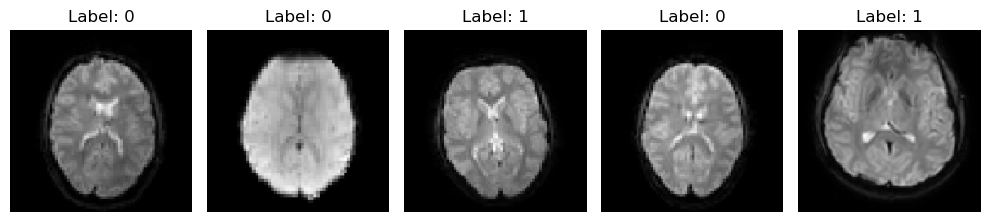

In [6]:
# Menampilkan 5 gambar dari set pelatihan
fig, axes = plt.subplots(1, 5, figsize=(10, 4))

for i, ax in enumerate(axes):
    img = train_data[i].permute(1, 2, 0)  # Mengubah dimensi tensor menjadi (H, W, C)
    label = train_labels[i]
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# **Split Data Train - Val**

# Memisahkan data pelatihan menjadi data validasi dan data pelatihan baru
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data,  # Data pelatihan yang sudah ada
    train_labels,  # Label pelatihan yang sudah ada
    test_size=0.3,  # Proporsi data validasi
    random_state=42  # Seed untuk reproduktibilitas
)

# Cetak jumlah data dalam set pelatihan dan set pengujian
print(f"Jumlah data pelatihan: {len(train_data)}")
print(f"Jumlah data pengujian: {len(val_data)}")

# Perbaikan pixel (buat jaga-jaga)

In [7]:
train_dataset = list(zip(train_data, train_labels))
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

test_dataset = list(zip(test_data, test_labels))
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [8]:
# Menginisialisasi model pretrained
model = models.vgg16(pretrained=True)

# Menonaktifkan penghitungan gradien untuk parameter model pretrained
for param in model.parameters():
    param.requires_grad = False

# Mengubah ukuran input pada lapisan konvolusi pertama
model.features[0] = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

# Mengganti layer terakhir (fully connected) pada model dengan layer baru
num_classes = 2  # Jumlah kelas
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 79.1MB/s] 


In [9]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# Menggunakan perangkat GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
# Mendifinisikan fungsi loss dan optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# **Train Model**

In [12]:
from sklearn.model_selection import KFold

train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

def train(model, device, train_loader, optimizer, epoch, train_indices, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    running_loss = 0.0
    running_corrects = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        logits = output
        output = F.softmax(output, dim=1)
        _, preds = torch.max(output, dim=1)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
        running_loss += loss.item()
        running_corrects += torch.sum(preds == target).item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects / len(train_indices)  # Use len(train_indices) instead of len(train_loader.dataset)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    print(epoch_loss)
    print(epoch_acc)


def val(model, device, val_loader, val_indices):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits = output
            val_loss += criterion(logits, target).item() # sum up batch loss
            pred_prob = torch.softmax(logits, dim=1) # apply softmax to output
            pred_class = torch.argmax(pred_prob, dim=1) # get the index of the max probability
            correct += pred_class.eq(target.view_as(pred_class)).sum().item()
    val_acc= correct/len(val_indices)  # Use len(val_indices) instead of len(val_loader.dataset)
    val_loss /= len(val_loader)
    valid_loss.append(val_loss)
    valid_accuracy.append(val_acc)
    print(val_loss)
    print(val_acc)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_indices),
        100. * correct / len(val_indices)))  # Use len(val_indices) instead of len(val_loader.dataset)

In [13]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 40
batch_size = 32

train_loss_per_fold = []
train_accuracy_per_fold = []
valid_loss_per_fold = []
valid_accuracy_per_fold = []

start_time = time.time()

for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{kf.get_n_splits()}")  # Using kf.get_n_splits() to get the number of splits

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
    val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, epoch, train_indices)
        val(model, device, val_loader, val_indices)

    # Store the outputs for each fold
    train_loss_per_fold.append(train_loss)
    train_accuracy_per_fold.append(train_accuracy)
    valid_loss_per_fold.append(valid_loss)
    valid_accuracy_per_fold.append(valid_accuracy)

print("--- %s seconds ---" % (time.time() - start_time))


Fold 1/5


  0%|          | 0/19 [00:00<?, ?it/s]

0.6986444498363295
0.5309882747068677
0.6995344758033752
0.48

Test set: Average loss: 0.6995, Accuracy: 72/150 (48%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.7005223537746229
0.5108877721943048
0.693040418624878
0.5133333333333333

Test set: Average loss: 0.6930, Accuracy: 77/150 (51%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.7003808711704455
0.507537688442211
0.6932165503501893
0.5266666666666666

Test set: Average loss: 0.6932, Accuracy: 79/150 (53%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6868861035296792
0.5360134003350083
0.687099277973175
0.5133333333333333

Test set: Average loss: 0.6871, Accuracy: 77/150 (51%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6895414810431632
0.5343383584589615
0.6849196314811706
0.5466666666666666

Test set: Average loss: 0.6849, Accuracy: 82/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6716350473855671
0.5912897822445561
0.6817874908447266
0.5533333333333333

Test set: Average loss: 0.6818, Accuracy: 83/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6774211996480038
0.5644891122278057
0.6820369482040405
0.5533333333333333

Test set: Average loss: 0.6820, Accuracy: 83/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6728812581614444
0.5845896147403685
0.6798959732055664
0.56

Test set: Average loss: 0.6799, Accuracy: 84/150 (56%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6566800788829201
0.6013400335008375
0.6800616383552551
0.56

Test set: Average loss: 0.6801, Accuracy: 84/150 (56%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6605793112202695
0.5996649916247906
0.673840868473053
0.58

Test set: Average loss: 0.6738, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6752840217791105
0.5778894472361809
0.676179039478302
0.5333333333333333

Test set: Average loss: 0.6762, Accuracy: 80/150 (53%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6645198966327467
0.5879396984924623
0.675276267528534
0.5866666666666667

Test set: Average loss: 0.6753, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6625297383258217
0.609715242881072
0.670164430141449
0.54

Test set: Average loss: 0.6702, Accuracy: 81/150 (54%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6716459644468207
0.5728643216080402
0.6716669917106628
0.5333333333333333

Test set: Average loss: 0.6717, Accuracy: 80/150 (53%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6483750845256605
0.6147403685092128
0.6684202790260315
0.5466666666666666

Test set: Average loss: 0.6684, Accuracy: 82/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6516859907852975
0.5896147403685092
0.6727827906608581
0.56

Test set: Average loss: 0.6728, Accuracy: 84/150 (56%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6473624361188788
0.6197654941373534
0.6687324047088623
0.5533333333333333

Test set: Average loss: 0.6687, Accuracy: 83/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6602912106012043
0.6046901172529313
0.674025583267212
0.54

Test set: Average loss: 0.6740, Accuracy: 81/150 (54%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6505905891719618
0.6113902847571189
0.6751621007919312
0.5533333333333333

Test set: Average loss: 0.6752, Accuracy: 83/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6620865997515226
0.6164154103852596
0.6693851590156555
0.5866666666666667

Test set: Average loss: 0.6694, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6415635880671049
0.6197654941373534
0.6732021570205688
0.5533333333333333

Test set: Average loss: 0.6732, Accuracy: 83/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6401748688597428
0.6465661641541038
0.6662977457046508
0.58

Test set: Average loss: 0.6663, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6597522999110975
0.626465661641541
0.6723569869995117
0.58

Test set: Average loss: 0.6724, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6471741575943796
0.6365159128978225
0.6726253867149353
0.5666666666666667

Test set: Average loss: 0.6726, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6493558444474873
0.6147403685092128
0.6647246360778809
0.58

Test set: Average loss: 0.6647, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6449804274659408
0.6247906197654941
0.6793864727020263
0.5666666666666667

Test set: Average loss: 0.6794, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6456890545393291
0.6147403685092128
0.6701160311698914
0.5533333333333333

Test set: Average loss: 0.6701, Accuracy: 83/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6472687282060322
0.6398659966499163
0.6691706418991089
0.5666666666666667

Test set: Average loss: 0.6692, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6510619521141052
0.6197654941373534
0.667619526386261
0.5733333333333334

Test set: Average loss: 0.6676, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6517840812080785
0.6113902847571189
0.6739711284637451
0.56

Test set: Average loss: 0.6740, Accuracy: 84/150 (56%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6357324437091225
0.6247906197654941
0.6700620174407959
0.5666666666666667

Test set: Average loss: 0.6701, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6481963270588925
0.6331658291457286
0.6667983412742615
0.5866666666666667

Test set: Average loss: 0.6668, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6410144002814042
0.644891122278057
0.6651404023170471
0.5866666666666667

Test set: Average loss: 0.6651, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6420085932079115
0.6348408710217756
0.6690342545509338
0.5733333333333334

Test set: Average loss: 0.6690, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6468350604960793
0.6113902847571189
0.666721510887146
0.5866666666666667

Test set: Average loss: 0.6667, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6427286424134907
0.626465661641541
0.6715671300888062
0.5933333333333334

Test set: Average loss: 0.6716, Accuracy: 89/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6534795196432817
0.5912897822445561
0.6610036849975586
0.5866666666666667

Test set: Average loss: 0.6610, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6434489363118222
0.6432160804020101
0.6681246876716613
0.5733333333333334

Test set: Average loss: 0.6681, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6392505608106914
0.6314907872696818
0.6758796215057373
0.5866666666666667

Test set: Average loss: 0.6759, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6454579641944483
0.6331658291457286
0.6684140086174011
0.5866666666666667

Test set: Average loss: 0.6684, Accuracy: 88/150 (59%)

Fold 2/5


  0%|          | 0/19 [00:00<?, ?it/s]

0.6419306930742765
0.6499162479061976
0.6821678757667542
0.5666666666666667

Test set: Average loss: 0.6822, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6336277535087184
0.6432160804020101
0.6777392506599427
0.58

Test set: Average loss: 0.6777, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6335230877524928
0.6247906197654941
0.6795936942100524
0.5933333333333334

Test set: Average loss: 0.6796, Accuracy: 89/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6359327121784812
0.6532663316582915
0.6872381925582886
0.5666666666666667

Test set: Average loss: 0.6872, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6337470600479528
0.6482412060301508
0.6753150701522828
0.5733333333333334

Test set: Average loss: 0.6753, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6397637881730732
0.6432160804020101
0.6766992330551147
0.5733333333333334

Test set: Average loss: 0.6767, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6363748845301176
0.6331658291457286
0.6753471374511719
0.6266666666666667

Test set: Average loss: 0.6753, Accuracy: 94/150 (63%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6282890784113031
0.6365159128978225
0.6887303471565247
0.56

Test set: Average loss: 0.6887, Accuracy: 84/150 (56%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6345131020796927
0.6432160804020101
0.6799826264381409
0.5733333333333334

Test set: Average loss: 0.6800, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6331021409285696
0.6314907872696818
0.6859323859214783
0.58

Test set: Average loss: 0.6859, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6259188746151171
0.6381909547738693
0.6844235062599182
0.5733333333333334

Test set: Average loss: 0.6844, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6144376867695859
0.6700167504187605
0.6782378077507019
0.58

Test set: Average loss: 0.6782, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6224956230113381
0.644891122278057
0.6869110941886902
0.5866666666666667

Test set: Average loss: 0.6869, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6217730609994185
0.6415410385259631
0.6931420207023621
0.5866666666666667

Test set: Average loss: 0.6931, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6474632777665791
0.6314907872696818
0.6867646217346192
0.5866666666666667

Test set: Average loss: 0.6868, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6242671483441403
0.6398659966499163
0.6844459295272827
0.58

Test set: Average loss: 0.6844, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6276968999912864
0.6398659966499163
0.6812638282775879
0.5866666666666667

Test set: Average loss: 0.6813, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6419795124154342
0.6348408710217756
0.6909402728080749
0.5733333333333334

Test set: Average loss: 0.6909, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6303185099049619
0.6365159128978225
0.6817045092582703
0.5866666666666667

Test set: Average loss: 0.6817, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6352572786180597
0.6566164154103853
0.6873427152633667
0.5733333333333334

Test set: Average loss: 0.6873, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6301207887498956
0.6314907872696818
0.6913648009300232
0.5733333333333334

Test set: Average loss: 0.6914, Accuracy: 86/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6201850520937067
0.6465661641541038
0.6815461993217469
0.58

Test set: Average loss: 0.6815, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6281523579045346
0.6432160804020101
0.6861693859100342
0.5866666666666667

Test set: Average loss: 0.6862, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6140446349194175
0.6817420435510888
0.6948619246482849
0.58

Test set: Average loss: 0.6949, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6174270730269583
0.6599664991624791
0.6937416076660157
0.5666666666666667

Test set: Average loss: 0.6937, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6222598615445589
0.6532663316582915
0.6959618330001831
0.5666666666666667

Test set: Average loss: 0.6960, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6243275466718172
0.6633165829145728
0.6808599829673767
0.5933333333333334

Test set: Average loss: 0.6809, Accuracy: 89/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6155811360007838
0.6683417085427136
0.6896316409111023
0.5866666666666667

Test set: Average loss: 0.6896, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6238340327614232
0.6716917922948074
0.6890227794647217
0.5933333333333334

Test set: Average loss: 0.6890, Accuracy: 89/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6153514416594255
0.661641541038526
0.6929437398910523
0.5666666666666667

Test set: Average loss: 0.6929, Accuracy: 85/150 (57%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6199681429486525
0.6532663316582915
0.6835389256477356
0.6

Test set: Average loss: 0.6835, Accuracy: 90/150 (60%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6271142583144339
0.6197654941373534
0.6822060108184814
0.5933333333333334

Test set: Average loss: 0.6822, Accuracy: 89/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6380346260572735
0.628140703517588
0.6893573760986328
0.5933333333333334

Test set: Average loss: 0.6894, Accuracy: 89/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6135643783368563
0.661641541038526
0.6938217401504516
0.5866666666666667

Test set: Average loss: 0.6938, Accuracy: 88/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6175581248183
0.6599664991624791
0.6968778252601624
0.58

Test set: Average loss: 0.6969, Accuracy: 87/150 (58%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6264847360159221
0.6465661641541038
0.6813459753990173
0.5933333333333334

Test set: Average loss: 0.6813, Accuracy: 89/150 (59%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6331397451852497
0.6398659966499163
0.693687093257904
0.5533333333333333

Test set: Average loss: 0.6937, Accuracy: 83/150 (55%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6166010640169445
0.6633165829145728
0.6772535085678101
0.6

Test set: Average loss: 0.6773, Accuracy: 90/150 (60%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6291307712856092
0.6499162479061976
0.6965770125389099
0.56

Test set: Average loss: 0.6966, Accuracy: 84/150 (56%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6142108612938931
0.6432160804020101
0.6808425188064575
0.6

Test set: Average loss: 0.6808, Accuracy: 90/150 (60%)

Fold 3/5


  0%|          | 0/19 [00:00<?, ?it/s]

0.640615093080621
0.6321070234113713
0.5967981576919555
0.7046979865771812

Test set: Average loss: 0.5968, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6309489717609004
0.6321070234113713
0.594280207157135
0.6912751677852349

Test set: Average loss: 0.5943, Accuracy: 103/149 (69%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6531984649206463
0.6103678929765887
0.5938759088516236
0.6912751677852349

Test set: Average loss: 0.5939, Accuracy: 103/149 (69%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6359138018206546
0.6321070234113713
0.5967793822288513
0.697986577181208

Test set: Average loss: 0.5968, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6461109926826075
0.6070234113712375
0.5910184383392334
0.697986577181208

Test set: Average loss: 0.5910, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6376895214381971
0.6454849498327759
0.5994876742362976
0.697986577181208

Test set: Average loss: 0.5995, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6342362918351826
0.6555183946488294
0.5963642597198486
0.6912751677852349

Test set: Average loss: 0.5964, Accuracy: 103/149 (69%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6380139306971901
0.6555183946488294
0.5964800953865051
0.6778523489932886

Test set: Average loss: 0.5965, Accuracy: 101/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6281238951181111
0.6605351170568562
0.5968289613723755
0.7046979865771812

Test set: Average loss: 0.5968, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6408918547002893
0.6003344481605352
0.5966723203659058
0.7114093959731543

Test set: Average loss: 0.5967, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6441914439201355
0.6270903010033445
0.6023658156394959
0.7114093959731543

Test set: Average loss: 0.6024, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6423101911419317
0.6387959866220736
0.596614146232605
0.697986577181208

Test set: Average loss: 0.5966, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6363070450331035
0.6387959866220736
0.6016563534736633
0.6912751677852349

Test set: Average loss: 0.6017, Accuracy: 103/149 (69%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6382814614396346
0.6254180602006689
0.6004754304885864
0.697986577181208

Test set: Average loss: 0.6005, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6370687171032554
0.6638795986622074
0.603960144519806
0.6912751677852349

Test set: Average loss: 0.6040, Accuracy: 103/149 (69%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6410322252072786
0.6337792642140468
0.6021634459495544
0.6912751677852349

Test set: Average loss: 0.6022, Accuracy: 103/149 (69%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6351431419974879
0.6220735785953178
0.6030160546302795
0.6912751677852349

Test set: Average loss: 0.6030, Accuracy: 103/149 (69%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6371639653256065
0.6505016722408027
0.597693783044815
0.6778523489932886

Test set: Average loss: 0.5977, Accuracy: 101/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6386884952846327
0.6505016722408027
0.6123313665390014
0.697986577181208

Test set: Average loss: 0.6123, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6226684482474076
0.6588628762541806
0.6034584641456604
0.697986577181208

Test set: Average loss: 0.6035, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6330695685587431
0.6471571906354515
0.6101146936416626
0.7046979865771812

Test set: Average loss: 0.6101, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6321461624220798
0.6488294314381271
0.6037915587425232
0.697986577181208

Test set: Average loss: 0.6038, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6377200986209669
0.6387959866220736
0.5980321884155273
0.6845637583892618

Test set: Average loss: 0.5980, Accuracy: 102/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6324416555856404
0.6304347826086957
0.6032785058021546
0.7046979865771812

Test set: Average loss: 0.6033, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6370607332179421
0.6120401337792643
0.6015241503715515
0.7046979865771812

Test set: Average loss: 0.6015, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6349752137535497
0.6538461538461539
0.605962485074997
0.6912751677852349

Test set: Average loss: 0.6060, Accuracy: 103/149 (69%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6497983085481744
0.6354515050167224
0.6069129705429077
0.7046979865771812

Test set: Average loss: 0.6069, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6320226631666485
0.6471571906354515
0.6052624106407165
0.6778523489932886

Test set: Average loss: 0.6053, Accuracy: 101/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6369479361333346
0.6354515050167224
0.6058892965316772
0.7114093959731543

Test set: Average loss: 0.6059, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.638484609754462
0.6187290969899666
0.600549864768982
0.7046979865771812

Test set: Average loss: 0.6005, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6332402370477977
0.657190635451505
0.5982990384101867
0.7114093959731543

Test set: Average loss: 0.5983, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6275928569467444
0.6404682274247492
0.6058896780014038
0.6778523489932886

Test set: Average loss: 0.6059, Accuracy: 101/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6332753990825853
0.6337792642140468
0.6018136739730835
0.7046979865771812

Test set: Average loss: 0.6018, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6443869142155898
0.6488294314381271
0.6070815443992614
0.6845637583892618

Test set: Average loss: 0.6071, Accuracy: 102/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6398343098791022
0.637123745819398
0.6073370575904846
0.7046979865771812

Test set: Average loss: 0.6073, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6329012575902437
0.6321070234113713
0.6061106324195862
0.6845637583892618

Test set: Average loss: 0.6061, Accuracy: 102/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.634769430286006
0.6421404682274248
0.6016889214515686
0.7046979865771812

Test set: Average loss: 0.6017, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6307018995285034
0.6505016722408027
0.6113003730773926
0.7114093959731543

Test set: Average loss: 0.6113, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6255041941216117
0.657190635451505
0.6053671360015869
0.7114093959731543

Test set: Average loss: 0.6054, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6427759496789229
0.6321070234113713
0.6032952785491943
0.6912751677852349

Test set: Average loss: 0.6033, Accuracy: 103/149 (69%)

Fold 4/5


  0%|          | 0/19 [00:00<?, ?it/s]

0.632008759598983
0.6488294314381271
0.5988151907920838
0.6644295302013423

Test set: Average loss: 0.5988, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6392448669985721
0.6321070234113713
0.6046973466873169
0.6644295302013423

Test set: Average loss: 0.6047, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6305161620441236
0.6321070234113713
0.595662796497345
0.7046979865771812

Test set: Average loss: 0.5957, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6308376883205614
0.6421404682274248
0.5934083104133606
0.697986577181208

Test set: Average loss: 0.5934, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6392892034430253
0.6454849498327759
0.5989896893501282
0.6644295302013423

Test set: Average loss: 0.5990, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6378783677753649
0.6387959866220736
0.5916649103164673
0.7114093959731543

Test set: Average loss: 0.5917, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6364186186539499
0.637123745819398
0.5970954418182373
0.6644295302013423

Test set: Average loss: 0.5971, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.63418090657184
0.6321070234113713
0.6034902334213257
0.6644295302013423

Test set: Average loss: 0.6035, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6332715561515406
0.6270903010033445
0.602136206626892
0.697986577181208

Test set: Average loss: 0.6021, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6387326309555456
0.6538461538461539
0.6004078626632691
0.6577181208053692

Test set: Average loss: 0.6004, Accuracy: 98/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6278263550055655
0.6505016722408027
0.5938341736793518
0.697986577181208

Test set: Average loss: 0.5938, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6307165654082048
0.6404682274247492
0.6027373313903809
0.6577181208053692

Test set: Average loss: 0.6027, Accuracy: 98/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6256238692685178
0.6488294314381271
0.601097023487091
0.6577181208053692

Test set: Average loss: 0.6011, Accuracy: 98/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6448245205377278
0.6287625418060201
0.5986821174621582
0.6644295302013423

Test set: Average loss: 0.5987, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6300675037660097
0.6387959866220736
0.6040921568870544
0.6778523489932886

Test set: Average loss: 0.6041, Accuracy: 101/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.643013386349929
0.6471571906354515
0.6040097117424011
0.6644295302013423

Test set: Average loss: 0.6040, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6192043549136111
0.6672240802675585
0.5986625671386718
0.6510067114093959

Test set: Average loss: 0.5987, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6237427717760989
0.6605351170568562
0.5983405828475952
0.6711409395973155

Test set: Average loss: 0.5983, Accuracy: 100/149 (67%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6267714500427246
0.6304347826086957
0.6001052260398865
0.6845637583892618

Test set: Average loss: 0.6001, Accuracy: 102/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6314913505002072
0.6220735785953178
0.602547824382782
0.6442953020134228

Test set: Average loss: 0.6025, Accuracy: 96/149 (64%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.628568526945616
0.6471571906354515
0.6087180256843567
0.6711409395973155

Test set: Average loss: 0.6087, Accuracy: 100/149 (67%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6236520111560822
0.6505016722408027
0.5998199343681335
0.6510067114093959

Test set: Average loss: 0.5998, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6276383431334245
0.6287625418060201
0.5980970144271851
0.6644295302013423

Test set: Average loss: 0.5981, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6238302462979367
0.6337792642140468
0.6030335426330566
0.6510067114093959

Test set: Average loss: 0.6030, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6302804915528548
0.637123745819398
0.6076637506484985
0.6442953020134228

Test set: Average loss: 0.6077, Accuracy: 96/149 (64%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6275096974874798
0.6354515050167224
0.6050943017005921
0.6510067114093959

Test set: Average loss: 0.6051, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6135688282941517
0.6605351170568562
0.6005064129829407
0.6510067114093959

Test set: Average loss: 0.6005, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6209806674405148
0.6538461538461539
0.6126315832138062
0.6442953020134228

Test set: Average loss: 0.6126, Accuracy: 96/149 (64%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6296375958543075
0.6454849498327759
0.6066628813743591
0.6845637583892618

Test set: Average loss: 0.6067, Accuracy: 102/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6246706529667503
0.6387959866220736
0.5957652926445007
0.6711409395973155

Test set: Average loss: 0.5958, Accuracy: 100/149 (67%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6167078771089253
0.6688963210702341
0.6061587929725647
0.6510067114093959

Test set: Average loss: 0.6062, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6234120381505865
0.6588628762541806
0.5896484136581421
0.6711409395973155

Test set: Average loss: 0.5896, Accuracy: 100/149 (67%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6435519237267343
0.6505016722408027
0.6118280053138733
0.6644295302013423

Test set: Average loss: 0.6118, Accuracy: 99/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6187468406401182
0.6605351170568562
0.6058080077171326
0.6577181208053692

Test set: Average loss: 0.6058, Accuracy: 98/149 (66%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6355191751530296
0.6337792642140468
0.6088536500930786
0.6510067114093959

Test set: Average loss: 0.6089, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6202658697178489
0.6622073578595318
0.595821762084961
0.6510067114093959

Test set: Average loss: 0.5958, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6329760425969174
0.6454849498327759
0.6118468880653382
0.6510067114093959

Test set: Average loss: 0.6118, Accuracy: 97/149 (65%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6238840771348853
0.6538461538461539
0.6108472228050232
0.6442953020134228

Test set: Average loss: 0.6108, Accuracy: 96/149 (64%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.637576909441697
0.6153846153846154
0.5973713159561157
0.6711409395973155

Test set: Average loss: 0.5974, Accuracy: 100/149 (67%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6208547479227969
0.6387959866220736
0.606406819820404
0.6644295302013423

Test set: Average loss: 0.6064, Accuracy: 99/149 (66%)

Fold 5/5


  0%|          | 0/19 [00:00<?, ?it/s]

0.6222456191715441
0.6471571906354515
0.5734197854995727
0.7315436241610739

Test set: Average loss: 0.5734, Accuracy: 109/149 (73%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6352052876823827
0.6421404682274248
0.5656612336635589
0.738255033557047

Test set: Average loss: 0.5657, Accuracy: 110/149 (74%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6265427344723752
0.6505016722408027
0.5658512771129608
0.738255033557047

Test set: Average loss: 0.5659, Accuracy: 110/149 (74%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6430995432954085
0.6421404682274248
0.5687027931213379
0.7449664429530202

Test set: Average loss: 0.5687, Accuracy: 111/149 (74%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6398332181729769
0.6454849498327759
0.5809978127479554
0.7315436241610739

Test set: Average loss: 0.5810, Accuracy: 109/149 (73%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6364986488693639
0.6421404682274248
0.5785662233829498
0.7516778523489933

Test set: Average loss: 0.5786, Accuracy: 112/149 (75%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6393478355909649
0.6337792642140468
0.5825541257858277
0.7248322147651006

Test set: Average loss: 0.5826, Accuracy: 108/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6374782135612086
0.6471571906354515
0.5809961080551147
0.7248322147651006

Test set: Average loss: 0.5810, Accuracy: 108/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6197756372000042
0.6722408026755853
0.5758561015129089
0.7114093959731543

Test set: Average loss: 0.5759, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6318875394369426
0.6404682274247492
0.579629647731781
0.738255033557047

Test set: Average loss: 0.5796, Accuracy: 110/149 (74%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6327426935497084
0.6471571906354515
0.5734810829162598
0.7181208053691275

Test set: Average loss: 0.5735, Accuracy: 107/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6249932740864
0.637123745819398
0.5854406237602234
0.738255033557047

Test set: Average loss: 0.5854, Accuracy: 110/149 (74%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6222490982005471
0.657190635451505
0.5715978682041168
0.7449664429530202

Test set: Average loss: 0.5716, Accuracy: 111/149 (74%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6280322388598794
0.6354515050167224
0.5849480509757996
0.7114093959731543

Test set: Average loss: 0.5849, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6203441682614779
0.6421404682274248
0.588511323928833
0.7315436241610739

Test set: Average loss: 0.5885, Accuracy: 109/149 (73%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6251475403183385
0.6588628762541806
0.5839108824729919
0.7248322147651006

Test set: Average loss: 0.5839, Accuracy: 108/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6377990277189958
0.6471571906354515
0.5812381863594055
0.7248322147651006

Test set: Average loss: 0.5812, Accuracy: 108/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6268432799138521
0.6471571906354515
0.5872946739196777
0.7114093959731543

Test set: Average loss: 0.5873, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6241484911818254
0.6505016722408027
0.5816098213195801
0.7248322147651006

Test set: Average loss: 0.5816, Accuracy: 108/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6282075141605578
0.6438127090301003
0.5741535544395446
0.7516778523489933

Test set: Average loss: 0.5742, Accuracy: 112/149 (75%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6375816025232014
0.6404682274247492
0.5883619070053101
0.7315436241610739

Test set: Average loss: 0.5884, Accuracy: 109/149 (73%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6274100824406272
0.6421404682274248
0.5837824821472168
0.6845637583892618

Test set: Average loss: 0.5838, Accuracy: 102/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6212273522427207
0.6404682274247492
0.5876386642456055
0.7046979865771812

Test set: Average loss: 0.5876, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6169887028242412
0.6755852842809364
0.5871806621551514
0.7248322147651006

Test set: Average loss: 0.5872, Accuracy: 108/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6379861580698114
0.6287625418060201
0.5943247199058532
0.697986577181208

Test set: Average loss: 0.5943, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6260713307481063
0.6471571906354515
0.585040557384491
0.738255033557047

Test set: Average loss: 0.5850, Accuracy: 110/149 (74%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6123106918836895
0.6806020066889632
0.5882367849349975
0.7181208053691275

Test set: Average loss: 0.5882, Accuracy: 107/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.624735857311048
0.6454849498327759
0.5853951573371887
0.738255033557047

Test set: Average loss: 0.5854, Accuracy: 110/149 (74%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6456025462401541
0.6287625418060201
0.5851264834403992
0.6845637583892618

Test set: Average loss: 0.5851, Accuracy: 102/149 (68%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6133669803017064
0.6387959866220736
0.5921861469745636
0.7181208053691275

Test set: Average loss: 0.5922, Accuracy: 107/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6129835561702126
0.6822742474916388
0.5913366675376892
0.7315436241610739

Test set: Average loss: 0.5913, Accuracy: 109/149 (73%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6207365801459864
0.6471571906354515
0.5893712162971496
0.7181208053691275

Test set: Average loss: 0.5894, Accuracy: 107/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6032713635971672
0.68561872909699
0.5909273505210877
0.697986577181208

Test set: Average loss: 0.5909, Accuracy: 104/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6090424594126249
0.6755852842809364
0.5935569405555725
0.7181208053691275

Test set: Average loss: 0.5936, Accuracy: 107/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6273326152249387
0.6454849498327759
0.5858938932418823
0.7046979865771812

Test set: Average loss: 0.5859, Accuracy: 105/149 (70%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6228098759525701
0.6638795986622074
0.5941734194755555
0.7181208053691275

Test set: Average loss: 0.5942, Accuracy: 107/149 (72%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6120651615293402
0.6672240802675585
0.5885442137718201
0.7114093959731543

Test set: Average loss: 0.5885, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6198136586891977
0.6705685618729097
0.5886884808540345
0.7114093959731543

Test set: Average loss: 0.5887, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6250600971673664
0.6270903010033445
0.5975274205207824
0.7114093959731543

Test set: Average loss: 0.5975, Accuracy: 106/149 (71%)



  0%|          | 0/19 [00:00<?, ?it/s]

0.6270376287008587
0.6588628762541806
0.5882719039916993
0.7181208053691275

Test set: Average loss: 0.5883, Accuracy: 107/149 (72%)

--- 1313.36505651474 seconds ---


import time

start_time = time.time()

num_epoch = 100
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch, train_indices, val_indices)
    val(model, device, val_loader, val_indices)
    
    print("Epoch:", epoch)
    

print("--- %s seconds ---" % (time.time() - start_time))


# **Evaluasi Model**

In [14]:
# Evaluasi model pada data pengujian
model.eval()
test_loss = 0.0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch[0].to(device), batch[1].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
test_loss /= len(test_loader)

# Mencetak loss dan akurasi pada data pengujian
print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy*100:.2f}%")



Test Loss: 0.6869 - Test Accuracy: 60.75%


In [15]:
dictionary = {
    'train_loss':train_loss,
    'train_accuracy':train_accuracy,
    'val_loss':valid_loss,
    'val_accuracy':valid_accuracy
}
metrics = pd.DataFrame(dictionary)
metrics

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.698644,0.530988,0.699534,0.480000
1,0.700522,0.510888,0.693040,0.513333
2,0.700381,0.507538,0.693217,0.526667
3,0.686886,0.536013,0.687099,0.513333
4,0.689541,0.534338,0.684920,0.546667
...,...,...,...,...
195,0.622810,0.663880,0.594173,0.718121
196,0.612065,0.667224,0.588544,0.711409
197,0.619814,0.670569,0.588688,0.711409
198,0.625060,0.627090,0.597527,0.711409


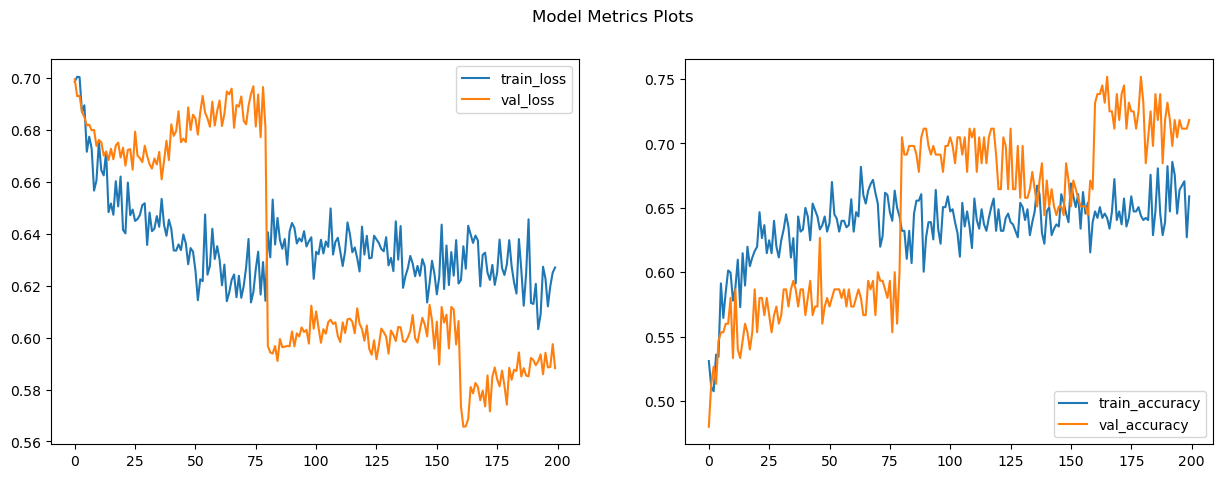

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Metrics Plots')

ax1.plot(metrics[['train_loss', 'val_loss']])
ax1.legend(['train_loss', 'val_loss'], loc="upper right")

ax2.plot(metrics[['train_accuracy', 'val_accuracy']])
ax2.legend(['train_accuracy', 'val_accuracy'], loc="lower right");

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = []
y_true = []

for data, labels in test_loader:
        data = data.to(torch.device('cuda'))
        output = model(data) # Feed Network
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

classes = ("Normal", "Autisme")

              precision    recall  f1-score   support

           0       0.56      0.74      0.64       152
           1       0.68      0.49      0.57       169

    accuracy                           0.61       321
   macro avg       0.62      0.61      0.60       321
weighted avg       0.62      0.61      0.60       321



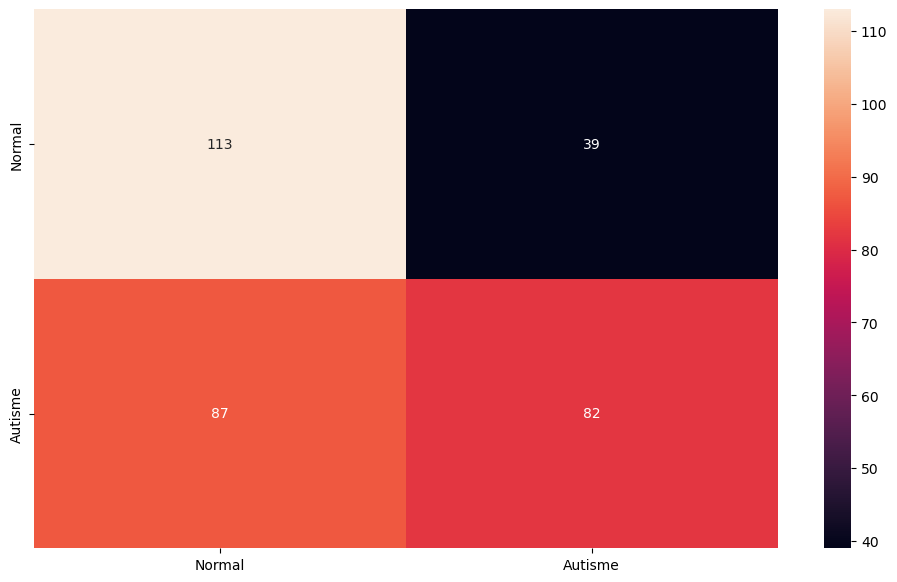

In [18]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, fmt="d",annot=True)
print(classification_report(y_true, y_pred))
